In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## Step 1 -- Posterior Interface

#### Here we determine how likely are a certain parameter values that we sampled using a log probability function.


## What “estimating parameters” actually means (Bayesian view)

In Bayesian inference, parameters are **not single numbers**.

They are **random variables**.

So the question is **not**:

> “What is the value of θ?”

It is:

> “How probable is each possible θ, given my data?”

That probability is exactly:

$
p(\theta \mid d)
$

So when you “estimate parameters”, you are really doing:

* Find **where** this distribution is large (best-fit)
* Find **how wide** it is (uncertainty)
* Find **how skewed / degenerate** it is

You cannot get any of that without knowing
**how probable a given θ is**.

---

## Why the sampler needs `log_prob(θ)`

An MCMC sampler does **not** solve equations.
It does **not** invert models.
It does **not** compute derivatives.

It does only one thing, over and over:

> Compare **two sets of parameters** and decide which is more probable.

To do that, it needs a number that answers:

> “How good is this θ compared to that θ?”

That number is the **log posterior probability**.

---

## Why *log* probability, not probability?

Two reasons:

### 1. Numerical stability

Likelihoods in astrophysics are often like:
$
\exp(-10^5)
$

That underflows to zero.

But:
$
\log p \sim -10^5
$

is perfectly fine.

### 2. Acceptance only depends on ratios

MCMC never uses absolute probabilities.
It only uses differences:

$
\log p(\theta') - \log p(\theta)
$

So logs are natural.

---

## How this leads to parameter estimates

Once the sampler runs, you get **samples**:

```python
theta_1, theta_2, theta_3, ...
```

These samples are drawn from:

$
p(\theta \mid d)
$

Now parameter estimation is trivial:

* Best-fit → mean / median / MAP
* Error bars → percentiles
* Correlations → joint distributions

The sampler doesn’t “estimate parameters”.
**You do**, from the samples.

---

## Analogy (important)

Think of `log_prob(θ)` like **χ²**.

In least squares you do:

```python
chi2(theta)
```

and then minimize it.

Here you do:

```python
log_prob(theta)
```

and then **explore** it.

Difference:

| Least squares | MCMC                    |
| ------------- | ----------------------- |
| Find minimum  | Map full landscape      |
| Local info    | Global info             |
| One answer    | Distribution of answers |

---

## Very concrete example

Say you have one parameter: cluster temperature (T).

You don’t know:

* Is T = 4.5 keV plausible?
* Is T = 6.0 keV plausible?

So you compute:

```python
log_prob(4.5)
log_prob(6.0)
```

Whichever is higher is more plausible.

MCMC just automates this comparison **millions of times**, intelligently.

---

## The key sentence (remember this)

> **You don’t give MCMC the answer.
> You give it a way to score answers.**

That score *is* `log_prob`.

---

## Why this is unavoidable

If you refuse to compute `p(θ | d)`:

* You cannot get uncertainties
* You cannot marginalize
* You cannot see degeneracies
* You cannot do Bayesian inference

At that point, you’re back to least squares.

---



In [ ]:
#### simplest posterior

def log_prob(theta):
    return -0.5*np.sum(theta**2)

theta = np.array($0.1, -0.2$)
print(log_prob(theta))

In [8]:
#### adding a hard prior #####
#### goals: Can I write a function that takes theta and returns a number?
        #   Does it return -np.inf for invalid points? WHY?- WE WANT TO ASSIGN ZERO PROBABILITY TO INVALID POINTS
#           Does it not crash?
def log_prob(theta):
    x,y=theta
    if x<=0:
        return -np.inf   # hard prior
    return -0.5 * (x - 1.0)**2 - 0.5 * y**2

print(log_prob(np.array([1.0, 0.0])))   # valid
print(log_prob(np.array([0.1, 2.0])))   # valid
print(log_prob(np.array([-1.0, 0.0])))  # invalid
print(log_prob(np.array([0.0, 1.0])))   # invalid

-0.0
-2.4050000000000002
-inf
-inf


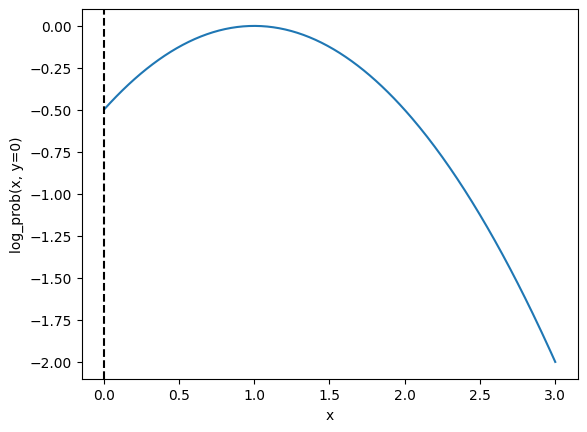

In [10]:
##### plotting the log-probability function for a set of parameters #####

import matplotlib.pyplot as plt

xs = np.linspace(-2, 3, 500)
ys = []

for x in xs:
    ys.append(log_prob(np.array([x, 0.0])))

plt.plot(xs, ys)
plt.axvline(0, color='k', linestyle='--')
plt.xlabel("x")
plt.ylabel("log_prob(x, y=0)")
plt.show()


Notice how the log probability vanishes for x<=0

# Step 2 -- The walkers (Ensemble)

#### The goal is to store multiple parameter vectors [theta1,theta2,..,], where, thetan=[param1,param2,param3].
#### Each vector is a walker. All walkers live in the same parameter space.

What must be stored (minimum)\
For an affine-invariant sampler, you need exactly two things:
1. The positions of the walkers
2. The log-probability at each position

In [11]:
n_walkers = 20
n_dim = 2

#walker positions
walkers=np.zeros((n_walkers,n_dim))

# log probabilities of each walker
log_probs=np.zeros(n_walkers)

Initializing the sampler

In [12]:
# initializing walkers near a guessed position
x0=np.array([1.0,0.0])

# sampling from a small gaussian ball around x0
walkers=x0+1e-2*np.random.randn(n_walkers,n_dim)

for i in range(n_walkers):
    log_probs[i]=log_prob(walkers[i])



## Why store logp separately?

Because calling `log_prob` is expensive.

Later:

* We reuse old values
* We only recompute when a proposal is accepted

This is a **huge speed win**.

---

## Minimal class (optional, but clean)


```python
class Ensemble:
    def __init__(self, walkers, logp):
        self.walkers = walkers
        self.logp = logp
```

But even this is optional.

---

## Important rules 

1. `n_walkers >= 2 * n_dim`
2. Walkers must **not all start at the same point**
3. Some walkers can start in low-probability regions — that’s okay

---

## Common mistakes

1. Using too few walkers
2. Forgetting to compute `logp` initially
3. Recomputing `log_prob` unnecessarily
4. Initializing all walkers identically





## Step 3 - The Stretch Factor


## Why do we need `z`?

In an affine-invariant sampler, a walker moves **along the line** connecting it to another walker.

`z` tells us **how far** along that line to go:

* `z < 1` → move closer
* `z > 1` → move farther away

To keep the algorithm *correct* (detailed balance), `z` **cannot** be uniform.

---

## The required distribution

For the Goodman–Weare stretch move:

$
g(z) \propto \frac{1}{\sqrt{z}}, \quad z \in \left[\frac{1}{a}, a\right]
$

* `a` is a fixed constant (usually `a = 2`)
* This choice ensures affine invariance


---


## Important intuition 

This distribution balances:

* **Small steps** → good acceptance
* **Large steps** → exploration

That balance is what makes the sampler:

* Fast
* Stable
* Tuning-free



In [ ]:
def z_sample(a=2.0):
    u=np.random.rand()
    z=((a-1)*u+1)**2/a
    return z

zs = [z_sample() for _ in range(10000)]
print(min(zs), max(zs))                    # should be between 1/a and a i.e. 0.5 and 2.0 for a=2

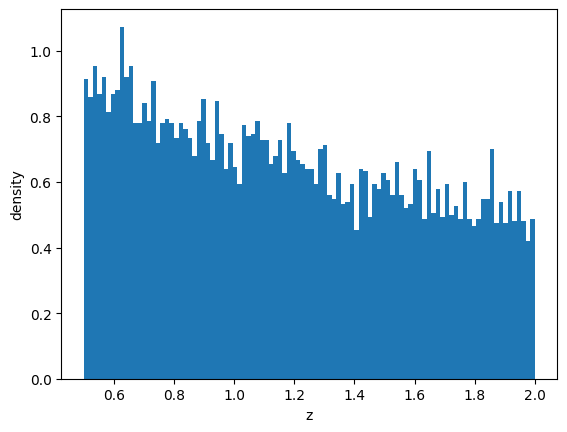

In [17]:
import matplotlib.pyplot as plt

plt.hist(zs, bins=100, density=True)
plt.xlabel("z")
plt.ylabel("density")
plt.show()


Notice how the distribution is not uniform even though the raw materials used were from a uniform distribution.